In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from statsmodels.tools import eval_measures
from scipy.optimize import least_squares, minimize, basinhopping, shgo, Bounds
from sklearn.utils.validation import  check_is_fitted
import statsmodels.formula.api as smf
import statsmodels.api as sm
from warnings import filterwarnings
filterwarnings('ignore')

The Data Class

In [212]:
class DengueData():
    def __init__(self, impute=None, test_setsz=.2):

        features = pd.read_csv('../Data/dengue_features_train.csv')
        features.index = pd.DatetimeIndex(features.week_start_date)#.to_period("w")
        features.index = pd.MultiIndex.from_tuples(list(zip(*[features.city, features.index])), names=['city', 'week_start_date'])
        self.features = features[features.columns[4:]]
        self.labels = pd.read_csv('../Data/dengue_labels_train.csv', index_col=[0, 1, 2])
        self.n_features, self.n_samples = self.features.shape
        self.feat_train, self.labels_train, self.feat_test, self.labels_test = [None] * 4
        if impute is not None:
            self.impute_missing(method=impute)

    def impute_missing(self, method):
        '''
        Method for imputting missing data

        :param method: str; how to impute missing values
            pad / ffill: propagate last valid observation forward to next valid
            backfill / bfill: use next valid observation to fill gap.
            mean: fill with the mean value of the feature
            median: fill with median value of the feature
            KNN: optimized K-nearest neighbors
        :return:
        '''

        if method in ['backfill', 'bfill', 'pad', 'ffill']:
            self.features = self.features.join(self.features.isna().astype(float), rsuffix='_miss')
            self.features.fillna(method=method, inplace=True)
        elif method == 'mean':
            self.features = self.features.join(self.features.isna().astype(int), rsuffix='_miss')
            self.features.fillna(value=self.features.mean(axis=0), inplace=True)
        elif method == 'median':
            self.features = self.features.join(self.features.isna().astype(int), rsuffix='_miss')
            self.features.fillna(value=self.features.median(axis=0), inplace=True)
        else:
            rmse = lambda actual, yhat: np.sqrt(mean_squared_error(actual, yhat))
            errors = {'K':[], 'RMSE':[]}
            for k in tqdm(range(1, 20, 2)):
                imputer = KNNImputer(n_neighbors=k, weights='distance')
                imputed = pd.DataFrame(imputer.fit_transform(self.features))
                feat_train, labels_train, feat_test, labels_test = self.split_train_test(x=imputed)
                model = RandomForestRegressor()
                model.fit(feat_train, labels_train.to_numpy().ravel())
                preds = model.predict(feat_test)
                error = rmse(labels_test, preds)
                errors['K'].append(k)
                errors['RMSE'].append(error)
            df_k = pd.DataFrame(errors)
            k = int(df_k.loc[df_k['RMSE'].idxmin()]['K'])
            imputer = KNNImputer(n_neighbors=k, weights='distance', add_indicator=True)
            self.features =  pd.DataFrame(imputer.fit_transform(self.features),
                                          columns = list(self.features.columns) + [v+'_miss' for v in self.features.columns],
                                          index=self.features.index)

    def split_train_test(self, inplace=False, append_labels=False, x=None, y=None, city=None,  test_setsz=.2):
        if city:
            self.features = self.features.loc[city]
            self.labels = self.labels.loc[city]
        if x is None:
            x = self.features
        if y is None:
            y = self.labels

        feat_train = x.iloc[:int(np.floor(len(x) * (1 - test_setsz)))]
        feat_test = x.iloc[:int(np.floor(len(x) * test_setsz))]

        labels_train = y.iloc[:int(np.floor(len(y) * (1 - test_setsz)))]
        labels_test = y.iloc[:int(np.floor(len(y) * test_setsz))]
        if append_labels:
            feat_train['total_cases'] = labels_train.total_cases.values
            feat_test['total_cases'] = labels_test.total_cases.values

        if inplace:
            self.feat_train, self.labels_train, self.feat_test, self.labels_test = [feat_train, labels_train, feat_test, labels_test]
            return
        else:
            return feat_train, labels_train, feat_test, labels_test

    def plot_case_dist(self):
        sns.displot(x='total_cases', col='city', data=self.labels);
        pass

    def plot_cases(self):
        sns.relplot(x=self.features.index.get_level_values(1), y=self.labels.total_cases, col=self.features.index.get_level_values(0), kind='line');


The Base Model Class

In [213]:

class DengueBaseModel():
    def __init__(self, data=None, params=None, param_bounds=None, n_rand_starts=10):
        '''

        :param data: instance of DengueData object
        :param params: dict, mapping of parameter name and value
        :param param_bounds: dict, mapping parameter name to tuple of value bounds (lower bound, higher bound)
        '''
        self.data=data
        self.data.split_train_test(inplace=True)
        if params is None:
            self.params = params
        else:
            for p in params:
                if params[p] is None:
                    if param_bounds is None:
                        param_bounds = {pr:[0,1] for pr in params}
                    params[p] = np.random.uniform(low=param_bounds[p][0], high=param_bounds[p][1])
        self.param_bounds = param_bounds
        self.n_random_starts = n_rand_starts

    def _objective_function(self):
        '''

        :param params:params to use in the model for predictions
        :return: mean absolute error between observations and model predictions
        '''
        preds = self.model()
        return eval_measures.meanabs(preds, self.data.labels_test)

    def model(self):
        print('modeling data')
        pass

    def predict(self, pred_params=None):
        if pred_params is not None:
            preds= self.model(params=[pred_params[x] for x in pred_params])
        else:
            preds = self.model(params=[self.params[x] for x in self.params]) #randomly initialized at init
        return preds

    def fit(self,  optimizer ='shgo'):
        '''Fit Model to outcomes given states

        Args:
            outcomes: (np.array) vector of trial outcomes (i.e., Player 2 decisions)
            observations: (np.array) vector of Player 3 predictions
            investments: (nparray) optional vector of P1 investments
            states:  (np.array) optional vector of states. must be same length as outcomes
            optimizer: (str) type of optimizer to use ['shgo','least_squares', 'basinhopping','minimize']
            init_values: (dict) dictionary of initial values for each state
        '''

        # Optimizer to estimate parameters - going with shgo for now.
        if optimizer == 'shgo':
            self.opt_results = shgo(func=self._objective_function, bounds=[self.param_bounds[x] for x in self.param_bounds])
        elif optimizer == 'least_squares':
            self.opt_results = least_squares(fun=self._objective_function, x0=[self.params[x] for x in self.params], bounds=([self.param_bounds[x][0] for x in self.param_bounds], [self.param_bounds[x][1] for x in self.param_bounds]))
        elif optimizer == 'basinhopping':
            self.opt_results = basinhopping(self._objective_function, x0=[self.params[x] for x in self.params], niter=self.n_random_starts, minimizer_kwargs={'bounds':[self.param_bounds[x] for x in self.param_bounds]})
        elif optimizer == 'minimize':
            self.opt_results = minimize(fun=self._objective_function, x0=np.array([self.params[x] for x in self.params]), bounds=[Bounds(self.param_bounds[x][0], self.param_bounds[x][1]) for x in self.param_bounds], constraints=None)
        else:
            raise ValueError("optimizer must be ['shgo','least_squares', 'basinhopping','minimize']")

        self.sse_ = self.opt_results['fun']
        self.params = {x:y for x,y in zip(self.params, self.opt_results['x'])}

    def bic(self):
        '''Compute Bayesian Information Criterion'''
        check_is_fitted(self)
        return self.n_trials * np.log(self.sse_ / self.n_trials) + len(self.params) * np.log(self.n_trials)

    def aic(self):
        '''Compute Akaike Information Criterion'''
        check_is_fitted(self)
        return self.n_trials * np.log(self.sse_ / self.n_trials) + 2 * len(self.params)


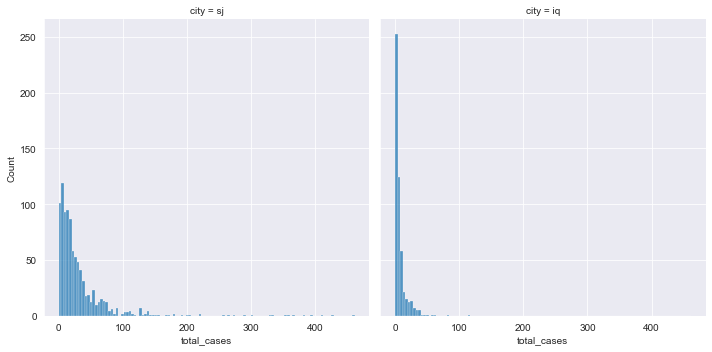

In [214]:
dat = DengueData(impute='ffill')
dat.plot_case_dist()

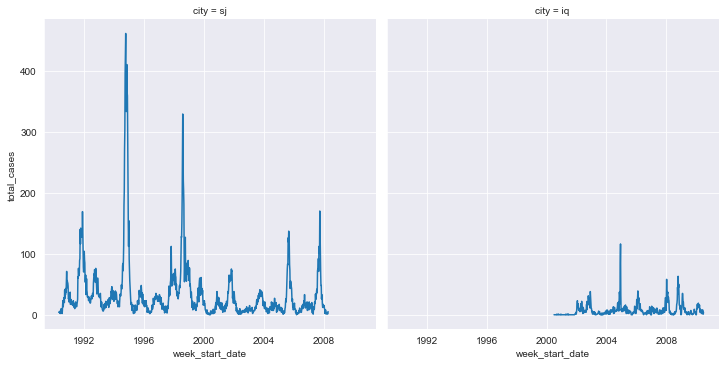

In [215]:
dat.plot_cases()

In [239]:
class NegativeBinomial(DengueBaseModel):
    def __init__(self, data, params, param_bounds):
        super(NegativeBinomial, self).__init__(data=data, params=params, param_bounds=param_bounds)
        self.data.split_train_test(inplace=True, append_labels=True, city='sj')
        self.params=params
        #self.model_formula


    def model(self):
        self.model_formula = 'total_cases ~ + 1 '+" ".join(['+ '+v for v in self.data.features.columns])
        mod = smf.glm(formula=self.model_formula, data=self.data.feat_train, family=sm.families.NegativeBinomial()).fit()
        return mod.predict(self.data.feat_test)

In [238]:
nb = NegativeBinomial(data = DengueData(impute='mean'), params={'alpha': None}, param_bounds={'alpha':[-1, 1]})
nb.fit(optimizer='basin')

TypeError: model() takes 1 positional argument but 2 were given

In [229]:

nb.params
#nb.model(params=nb.params)
m = nb.model()

In [231]:
mm = m.fit()
mm.predict(nb.data.feat_test)
#sum(nb.data.labels_train.total_cases < 0)
#m.predict(nb.params['alpha'])

week_start_date
1990-04-30    22.318206
1990-05-07    25.474206
1990-05-14    23.684431
1990-05-21    27.478088
1990-05-28    27.193606
                ...    
1993-10-29    37.171845
1993-11-05    35.953006
1993-11-12    26.029589
1993-11-19    36.442966
1993-11-26    40.454224
Length: 187, dtype: float64

In [2]:
X = pd.read_csv('../Data/feature_train_clean_Knn.csv', index_col=0)
X = X.loc[X.city == 'sj']
X.sort_values(['year', 'weekofyear'], inplace=True)
#X.index = pd.DatetimeIndex(X.week_start_date).to_period('W')
#X.drop('week_start_date', inplace=True, axis=1)
X['week_start_date'] = pd.to_datetime(X.week_start_date)
#X.set_index('week_start_date', inplace=True)
Y = pd.read_csv('../Data/dengue_labels_train.csv')
Y = Y.loc[Y.city == 'sj']

In [3]:
X.head()


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent_miss,reanalysis_sat_precip_amt_mm_miss,reanalysis_specific_humidity_g_per_kg_miss,reanalysis_tdtr_k_miss,station_avg_temp_c_miss,station_diur_temp_rng_c_miss,station_max_temp_c_miss,station_min_temp_c_miss,station_precip_mm_miss,precipitation_amt_mm_miss
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
for c in X.city.unique():
    for y in X.loc[X.city == c].year.unique():
        for w in X.loc[(X.city == c) & (X.year == y)].weekofyear.unique():
            X.loc[(X.city == c) & (X.year == y) & (X.weekofyear == w), 'total_cases'] = int(Y.loc[(Y.city == c) & (Y.year == y) & (Y.weekofyear == w), 'total_cases'].values)

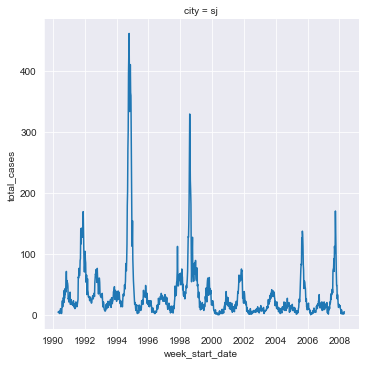

In [5]:
sns.relplot(x=X.week_start_date, y=X.total_cases, col=X.city, kind='line')

In [6]:
from datetime import timedelta

X.index = pd.DatetimeIndex(X.week_start_date)
rows = X.iterrows()
for i, r in rows:
    t1 = next(rows)[0]
    if i + timedelta(days=7) != t1:
        print('Not monotonically increasing')
        print(i)

Not monotonically increasing
1990-12-24 00:00:00
Not monotonically increasing
1991-12-24 00:00:00
Not monotonically increasing
1992-12-23 00:00:00
Not monotonically increasing
1993-01-01 00:00:00
Not monotonically increasing
1994-01-01 00:00:00
Not monotonically increasing
1995-01-01 00:00:00
Not monotonically increasing
1996-12-23 00:00:00
Not monotonically increasing
1997-12-24 00:00:00
Not monotonically increasing
1998-12-24 00:00:00
Not monotonically increasing
1999-01-01 00:00:00
Not monotonically increasing
2000-01-01 00:00:00
Not monotonically increasing
2001-12-24 00:00:00
Not monotonically increasing
2002-12-24 00:00:00
Not monotonically increasing
2003-12-24 00:00:00
Not monotonically increasing
2004-12-23 00:00:00
Not monotonically increasing
2005-01-01 00:00:00
Not monotonically increasing
2006-01-01 00:00:00
Not monotonically increasing
2007-12-24 00:00:00


In [9]:
i + timedelta(days=7)

Timestamp('1990-12-31 00:00:00')

In [53]:
X = X.reset_index()
X.index.is_monotonic_increasing

ValueError: cannot insert week_start_date, already exists

In [10]:
X.index = pd.DatetimeIndex(X.week_start_date).to_period("w")
X.drop('week_start_date', inplace=True, axis=1)
X

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_sat_precip_amt_mm_miss,reanalysis_specific_humidity_g_per_kg_miss,reanalysis_tdtr_k_miss,station_avg_temp_c_miss,station_diur_temp_rng_c_miss,station_max_temp_c_miss,station_min_temp_c_miss,station_precip_mm_miss,precipitation_amt_mm_miss,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30/1990-05-06,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1990-05-07/1990-05-13,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1990-05-14/1990-05-20,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1990-05-21/1990-05-27,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1990-05-28/1990-06-03,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-24/2008-03-30,sj,2008,13,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2008-03-31/2008-04-06,sj,2008,14,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2008-04-07/2008-04-13,sj,2008,15,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
#x_train, x_test, y_train, y_test = train_test_split(X[X.columns[1:-1]], X[['total_cases']], test_size=0.2, random_state=42)
# TODO: Don't split randomly. split by time K-fold3
test_size = .2
x_train =X.iloc[:int(np.floor(len(X) * (1 - test_size)))]
x_test = X.iloc[int(np.floor(len(X) * (1 - test_size))):]
x_train = x_train.asfreq('w')
x_train.index.is_monotonic_increasing

False

In [38]:
from datetime import timedelta
for w, r in X.iterrows():
    break

In [39]:
ARMA_model = SARIMAX(x_train['total_cases'], order=(1, 0, 1))
ARMA_model = ARMA_model.fit()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [47]:
y_pred = ARMA_model.get_forecast(len(x_test))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARMA_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# ARIMA

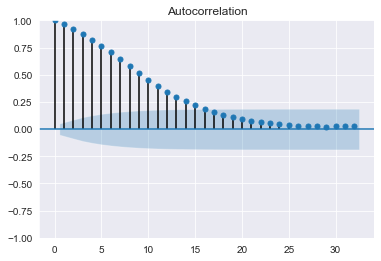

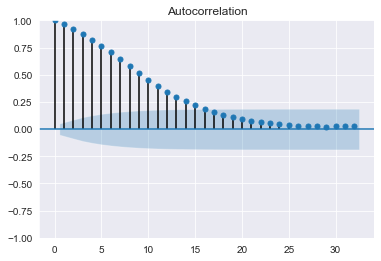

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
axes.set(ylim=(0,5))
plot_acf(X['total_cases'], ax=axes)

In [58]:
#pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0).value.diff()
X['total_cases'].diff()

week_start_date
1990-04-30    NaN
1990-05-07    1.0
1990-05-14   -1.0
1990-05-21   -1.0
1990-05-28    3.0
             ... 
2010-05-28   -1.0
2010-06-04    3.0
2010-06-11   -7.0
2010-06-18    0.0
2010-06-25    3.0
Name: total_cases, Length: 1456, dtype: float64

In [26]:
outcome = pd.DataFrame(index=X.index, data=Y['total_cases'].values)
outcome.columns = ['total_cases']Y
outcome

,total_cases
week_start_date,
1990-04-30,4
1990-05-07,5
1990-05-14,4
1990-05-21,3
1990-05-28,6
...,...
2010-05-28,5
2010-06-04,8
2010-06-11,1


## Testing for Stationarity

In [29]:
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary

result = adfuller(outcome['total_cases'])
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
for value,label in zip(result,labels):
    print(label+' : '+str(value) )
if result[1] <= 0.05:
    print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
else:
    print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

ADF Test Statistic : -6.623258235685168
p-value : 5.963285375798725e-09
#Lags Used : 12
Number of Observations Used : 1443
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


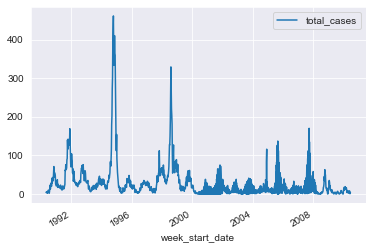

In [35]:
outcome.plot()

In [32]:
out_diff1 = outcome.diff()
out_diff2 = out_diff1.diff()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


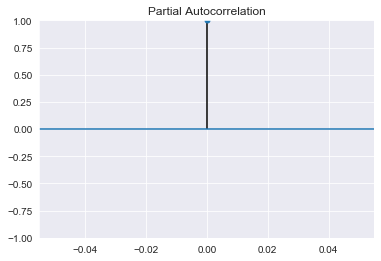

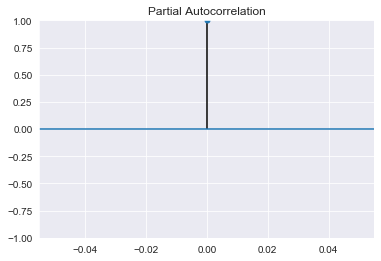

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(out_diff2)

In [6]:
# DIFFERENTIATING FIRST ORDER AUT0-REGRESSIVE ARIMA (1,1,0)C
darlt = sarima.SARIMAX(x_train, order=(1, 1, 0), trend='c').fit(disp=-1)
darlf = darlt.forecast(steps=len(y_train))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x_train, label='train')
#ax.plot(y_train, label='tr')


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [6]:
pm.datasets.load_wineind()

NameError: name 'pm' is not defined

In [7]:
import pmdarima as pm

ModuleNotFoundError: No module named 'pmdarima'

In [8]:
from pmdarima import auto_arima

ModuleNotFoundError: No module named 'pmdarima'